In [1]:
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

In [2]:
train_adc = pd.read_csv("/kaggle/input/ariel-data-challenge-2024/train_adc_info.csv")

In [3]:
class PlanetImages:
    TRAIN_IMGS_FOLDER = "/kaggle/input/ariel-data-challenge-2024/train"
    
    def __init__(self, img_num):
        self.img_num = img_num
        self.planet_corrections = train_adc.loc[train_adc.planet_id==img_num]
        
        self.image_folder = f"{PlanetImages.TRAIN_IMGS_FOLDER}/{img_num}"
        self.CH0_path  = f"{self.image_folder}/AIRS-CH0_signal.parquet"
        self.FGS1_path = f"{self.image_folder}/FGS1_signal.parquet"
        self.CH0_imgs = pd.read_parquet(self.CH0_path)   # each row is an image
        self.FGS1_imgs = pd.read_parquet(self.FGS1_path) # each row is an image
    
    def process_images(self, img_stack, device):
        """
        Apply image corrections which are inspired by this notebook
        https://www.kaggle.com/code/jnesbit6/sensor-noise-correction
        
        device: {'CH0', 'FGS1'}
        """
        if device=="CH0":
            dark_frame = pd.read_parquet(f"{PlanetImages.TRAIN_IMGS_FOLDER}/{self.img_num}/AIRS-CH0_calibration/dark.parquet").values.reshape(1,32,356)
            read_frame = pd.read_parquet(f"{PlanetImages.TRAIN_IMGS_FOLDER}/{self.img_num}/AIRS-CH0_calibration/read.parquet").values.reshape(1,32,356)
            flat_frame = pd.read_parquet(f"{PlanetImages.TRAIN_IMGS_FOLDER}/{self.img_num}/AIRS-CH0_calibration/flat.parquet").values.reshape(1,32,356)
            dead_frame = pd.read_parquet(f"{PlanetImages.TRAIN_IMGS_FOLDER}/{self.img_num}/AIRS-CH0_calibration/dead.parquet").values.reshape(1,32,356)
            flat_frame[dead_frame] = 1     
            gain   = self.planet_corrections["AIRS-CH0_adc_gain"].item()   # scalar
            offset = self.planet_corrections["AIRS-CH0_adc_offset"].item() # scalar
        else:
            dark_frame = pd.read_parquet(f"{PlanetImages.TRAIN_IMGS_FOLDER}/{self.img_num}/FGS1_calibration/dark.parquet").values.reshape(1,32,32)
            read_frame = pd.read_parquet(f"{PlanetImages.TRAIN_IMGS_FOLDER}/{self.img_num}/FGS1_calibration/read.parquet").values.reshape(1,32,32)
            flat_frame = pd.read_parquet(f"{PlanetImages.TRAIN_IMGS_FOLDER}/{self.img_num}/FGS1_calibration/flat.parquet").values.reshape(1,32,32)
            dead_frame = pd.read_parquet(f"{PlanetImages.TRAIN_IMGS_FOLDER}/{self.img_num}/FGS1_calibration/dead.parquet").values.reshape(1,32,32)
            flat_frame[dead_frame] = 1
            gain   = self.planet_corrections["FGS1_adc_gain"].item()    # scalar
            offset = self.planet_corrections["FGS1_adc_offset"].item()  # scalar
        ### Correction process
        img_stack = (img_stack - dark_frame - read_frame)/flat_frame 
        img_stack = img_stack*gain + offset
        return img_stack
    
    def plot_images(self, device, nrow:int, ncol:int, stack_size:int=10, figsize:tuple=(16,4)):
        """
        Displays a subset of images for a given device which are CORRECTED 
        using electronic characteristics and the corresponding gain and offset values. 
        
        device: {'CH0', 'FGS1'}
        nrow: row count for organizing all graphs.
        ncol: column count for organizing all graphs. 
        stack_size: how many images to select from a given device
        """
        if device=="CH0":
            img_stack = self.CH0_imgs.iloc[:stack_size, :].values.reshape(stack_size, 32, 356)
            
        elif device=="FGS1":
            img_stack = self.FGS1_imgs.iloc[:stack_size, :].values.reshape(stack_size, 32, 32)
            
        img_stack = self.process_images(img_stack, device)
        
        fig,axes = plt.subplots(nrow, ncol, figsize=figsize)
        axes = axes.ravel()
        for k in range(stack_size):
            img_k = img_stack[k, :, :]
            sea.heatmap(img_k, cmap="mako", square=True, ax=axes[k])
            axes[k].set_title(f"{device}: Image Number {k+1} for planet\n {self.img_num}", size=8)
            axes[k].set_xticks([])
            axes[k].set_yticks([])
            axes[k].set_xticklabels([])
            axes[k].set_yticklabels([])

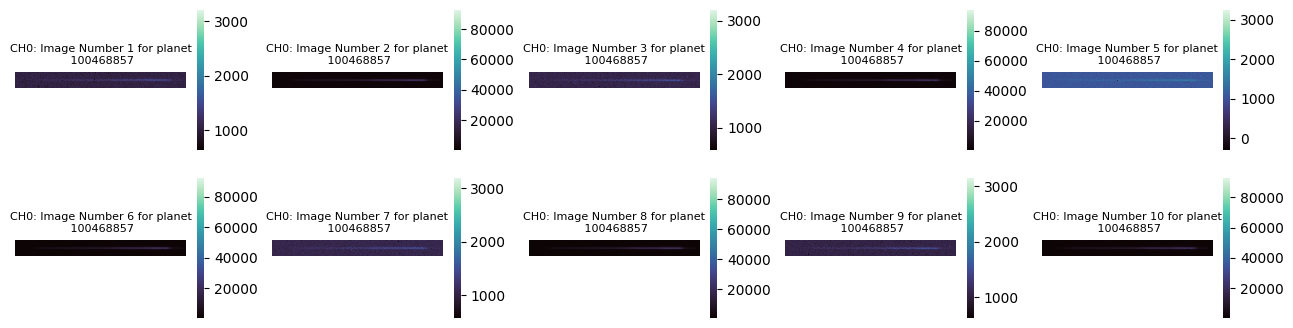

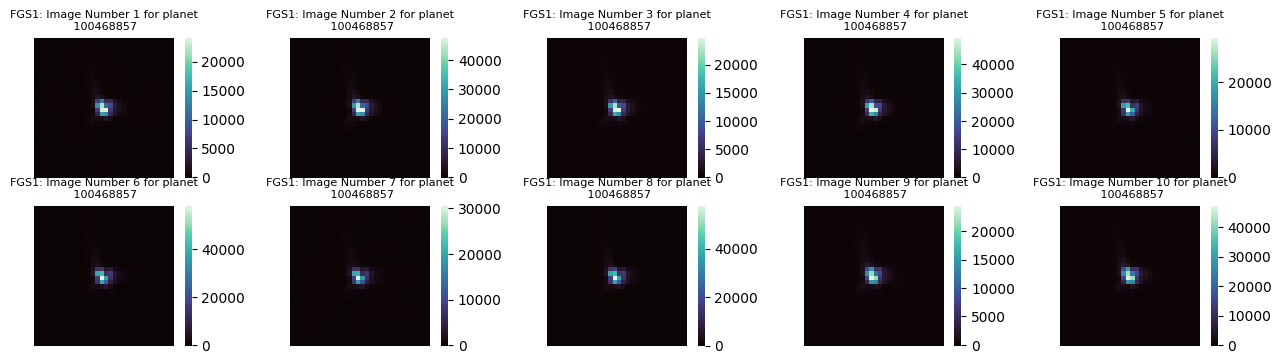

In [4]:
planet = PlanetImages(100468857)
planet.plot_images("CH0", nrow=2, ncol=5, stack_size=10)
planet.plot_images("FGS1", nrow=2, ncol=5, stack_size=10)

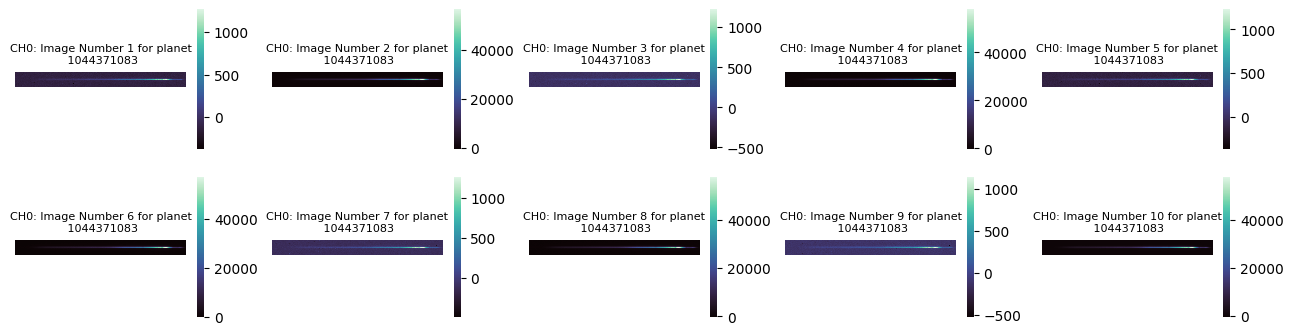

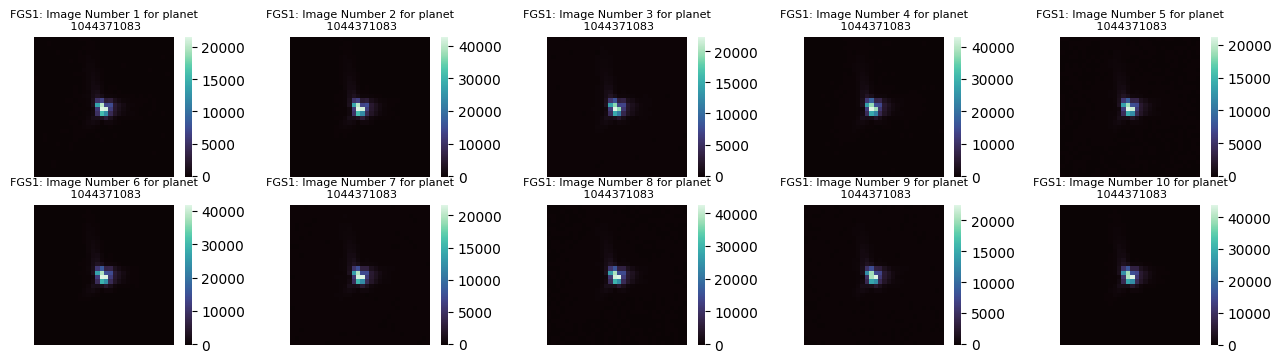

In [5]:
planet = PlanetImages(1044371083)
planet.plot_images("CH0", nrow=2, ncol=5, stack_size=10)
planet.plot_images("FGS1", nrow=2, ncol=5, stack_size=10)

# How about taking the difference between consecutive images?

In [6]:
cho_imgs = pd.read_parquet("/kaggle/input/ariel-data-challenge-2024/train/100468857/AIRS-CH0_signal.parquet")
leading_imgs = cho_imgs.iloc[1:, :].reset_index(drop=True)
lagging_imgs = cho_imgs.iloc[:-1, :].reset_index(drop=True)
diff = leading_imgs-lagging_imgs

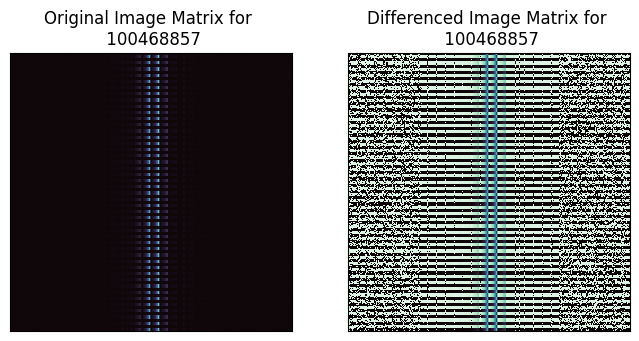

In [7]:
fig,axes = plt.subplots(1,2, figsize=(8,16))
axes[0].matshow(cho_imgs, cmap="mako")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Original Image Matrix for \n 100468857")

axes[1].matshow(diff, cmap="mako")
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("Differenced Image Matrix for \n 100468857")

plt.show()

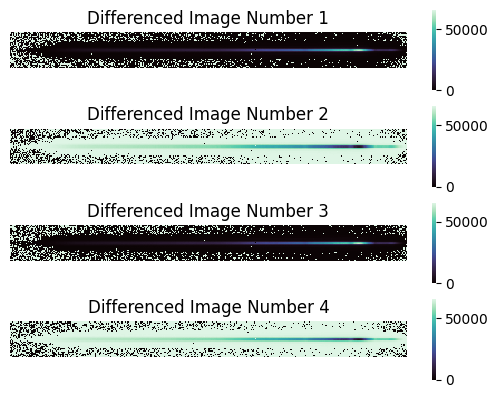

In [8]:
plt.subplot(411)
g = sea.heatmap(diff.iloc[0, :].values.reshape(32,356), cmap="mako", square=True)
g.set_xticks([])
g.set_yticks([])
g.set_xticklabels([])
g.set_yticklabels([])
g.set_title("Differenced Image Number 1")

plt.subplot(412)
g= sea.heatmap(diff.iloc[1, :].values.reshape(32,356), cmap="mako", square=True)
g.set_xticks([])
g.set_yticks([])
g.set_xticklabels([])
g.set_yticklabels([])
g.set_title("Differenced Image Number 2")

plt.subplot(413)
g = sea.heatmap(diff.iloc[2, :].values.reshape(32,356), cmap="mako", square=True)
g.set_xticks([])
g.set_yticks([])
g.set_xticklabels([])
g.set_yticklabels([])
g.set_title("Differenced Image Number 3")

plt.subplot(414)
g = sea.heatmap(diff.iloc[3, :].values.reshape(32,356), cmap="mako", square=True)
g.set_xticks([])
g.set_yticks([])
g.set_xticklabels([])
g.set_yticklabels([])
g.set_title("Differenced Image Number 4")

plt.show()